In [1]:

import mlrose_hiive
import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import string
import pandas as pd

from ast import literal_eval
import chess

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator, FourPeaks, FlipFlopGenerator, KnapsackGenerator
from mlrose_hiive import SARunner, GARunner, NNGSRunner
from mlrose_hiive import DiscreteOpt
from mlrose_hiive import SARunner, GARunner, NNGSRunner, RHCRunner
from A2_helpers.Four_peaks_helpers import Runner_overSeeds
import pandas as pd


# switch off the chatter
logging.basicConfig(level=logging.WARNING)

# fitness funcions list
#https://mlrose.readthedocs.io/en/stable/source/fitness.html#fitness

# about the mlrose setup
#https://mlrose.readthedocs.io/en/stable/source/tutorial1.html

# algos
# https://mlrose.readthedocs.io/en/stable/source/algorithms.html#algs


# Fitness / Iteration: Since we're dealing with optimization problems, those problems will present access to a fitness score at each iteration.

# Fitness / Problem Size: Focusing on a single problem size can misrepresent how well an algorithm is actually doing. To counteract this, try multiple problem sizes.

# Function Evaluations: There's many ways to interpret fevals. Some students will focus on fevals / wall clock times, or fevals / iterations, etc. The real requirement is that you somehow look at fevals. Keep in mind that some algorithms may take significantly less iterations but each iteration may take significantly longer.

# Wall Clock Time: Our favorite. Look into it.

## RHC Graphs

Collect Data Ran from A2P1Collection notebook

In [2]:
#kwargs = { "iteration_list":2 ** np.arange(11), "restart_list": [5,10,20,40,80],  "experiment_name": "RHC_runner"} 
# hyperparameters above
rhc_stats_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_stats_total_all_problem_sizes_rhc.csv")
rhc_curves_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_curves_total_all_problem_sizes_rhc.csv")

In [3]:
#kwargs = { "iteration_list":2 ** np.arange(11), "restart_list": [5,10,20,40,80],  "experiment_name": "RHC_runner"} 
# hyperparameters above
rhc_stats_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_stats_total_all_problem_sizes_rhc.csv")
rhc_curves_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_curves_total_all_problem_sizes_rhc.csv")

In [4]:
rhc_stats_all

,Unnamed: 0,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart,seed,problem_size
0,0,0,1.0,0,0.000169,"[3, 4, 0, 1, 3]",1,1024,0,1,5
1,1,1,1.0,1,0.001991,"[3, 4, 0, 1, 3]",1,1024,0,1,5
2,2,2,2.0,3,0.003289,"[3, 0, 0, 1, 3]",1,1024,0,1,5
3,3,4,3.0,6,0.004792,"[3, 3, 0, 1, 3]",1,1024,0,1,5
4,4,8,4.0,11,0.006485,"[3, 3, 1, 1, 3]",1,1024,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...
571,19,64,36.0,1151,0.399104,"[7, 14, 15, 4, 13, 22, 0, 4, 13, 7, 13, 7, 1, ...",1,1024,1,10,35
572,20,128,50.0,1222,0.429532,"[7, 7, 13, 13, 13, 4, 0, 4, 13, 7, 13, 7, 1, 4...",1,1024,1,10,35
573,21,256,80.0,1361,0.512062,"[7, 7, 13, 13, 13, 0, 0, 4, 13, 7, 13, 7, 1, 4...",1,1024,1,10,35
574,22,512,123.0,1628,0.655481,"[7, 7, 13, 13, 13, 0, 7, 0, 13, 13, 13, 7, 1, ...",1,1024,1,10,35


In [5]:
rhc_stats_all


,Unnamed: 0,Iteration,Fitness,FEvals,Time,State,Restarts,max_iters,current_restart,seed,problem_size
0,0,0,1.0,0,0.000169,"[3, 4, 0, 1, 3]",1,1024,0,1,5
1,1,1,1.0,1,0.001991,"[3, 4, 0, 1, 3]",1,1024,0,1,5
2,2,2,2.0,3,0.003289,"[3, 0, 0, 1, 3]",1,1024,0,1,5
3,3,4,3.0,6,0.004792,"[3, 3, 0, 1, 3]",1,1024,0,1,5
4,4,8,4.0,11,0.006485,"[3, 3, 1, 1, 3]",1,1024,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...
571,19,64,36.0,1151,0.399104,"[7, 14, 15, 4, 13, 22, 0, 4, 13, 7, 13, 7, 1, ...",1,1024,1,10,35
572,20,128,50.0,1222,0.429532,"[7, 7, 13, 13, 13, 4, 0, 4, 13, 7, 13, 7, 1, 4...",1,1024,1,10,35
573,21,256,80.0,1361,0.512062,"[7, 7, 13, 13, 13, 0, 0, 4, 13, 7, 13, 7, 1, 4...",1,1024,1,10,35
574,22,512,123.0,1628,0.655481,"[7, 7, 13, 13, 13, 0, 7, 0, 13, 13, 13, 7, 1, ...",1,1024,1,10,35


In [6]:
average_fitness_per_iteration = rhc_stats_all.groupby(['problem_size', 'Iteration'])['Fitness'].mean().reset_index()
std_fitness_per_iteration = rhc_stats_all.groupby(['problem_size', 'Iteration'])['Fitness'].std().reset_index()

# Rename columns for clarity
average_fitness_per_iteration.rename(columns={'Fitness': 'Average_Fitness'}, inplace=True)
std_fitness_per_iteration.rename(columns={'Fitness': 'Std_Fitness'}, inplace=True)

# Merge the average and standard deviation DataFrames
merged_fitness = pd.merge(average_fitness_per_iteration, std_fitness_per_iteration, on=['problem_size', 'Iteration'])

# Group by problem_size to get the max Average_Fitness per problem size
max_avg_fitness_per_problem_size = merged_fitness.groupby('problem_size')['Average_Fitness'].max().reset_index()

# Merge to find the rows with the max Average_Fitness per problem size
max_fitness_merged = pd.merge(merged_fitness, max_avg_fitness_per_problem_size, on=['problem_size', 'Average_Fitness'])

# For each problem_size, filter the row with the minimum Iteration
min_iteration_for_max_fitness = max_fitness_merged.loc[max_fitness_merged.groupby('problem_size')['Iteration'].idxmin()]
min_iteration_for_max_fitness


,problem_size,Iteration,Average_Fitness,Std_Fitness
0,5,128,10.000000,0.000000
4,15,512,92.833333,8.277388
6,25,1024,183.166667,32.651976
7,35,1024,204.833333,42.858824


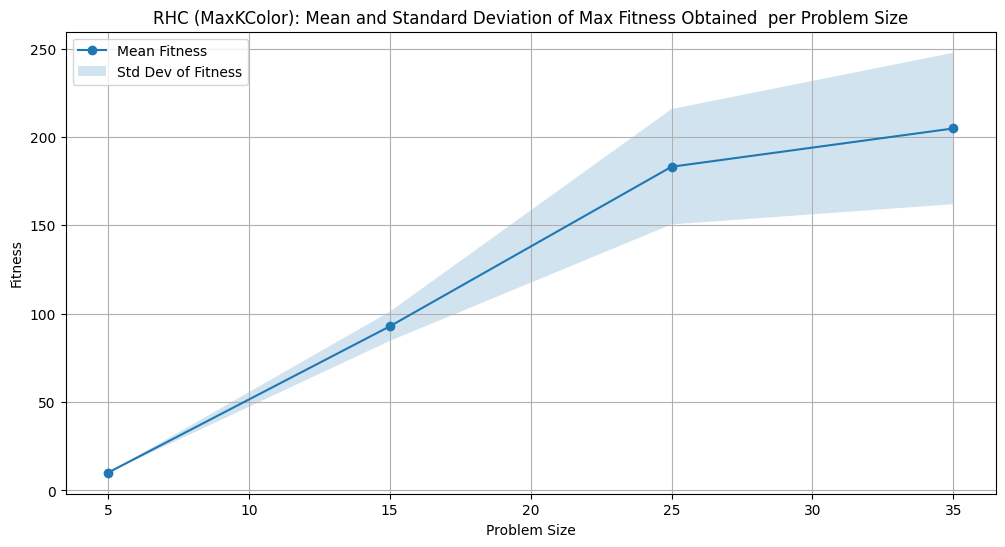

In [8]:
plt.figure(figsize=(12, 6))

# Plotting mean Fitness
plt.plot(rhc_stats_all['problem_size'].unique(), min_iteration_for_max_fitness["Average_Fitness"], 'o-', label='Mean Fitness')
plt.fill_between(min_iteration_for_max_fitness["problem_size"], 
                 min_iteration_for_max_fitness["Average_Fitness"] - min_iteration_for_max_fitness["Std_Fitness"], 
                 min_iteration_for_max_fitness["Average_Fitness"]+ min_iteration_for_max_fitness["Std_Fitness"], 
                 alpha=0.2, label='Std Dev of Fitness')



plt.xlabel('Problem Size')
plt.ylabel('Fitness')
plt.title('RHC (MaxKColor): Mean and Standard Deviation of Max Fitness Obtained  per Problem Size' )
plt.legend()
plt.grid(True)
plt.show()

    Iteration       mean       std
0           0   1.416667  0.792961
1           1   1.916667  0.792961
2           2   2.750000  1.215431
3           4   3.500000  1.314257
4           8   4.333333  1.614330
5          16   6.000000  1.477098
6          32   8.000000  2.088932
7          64   9.666667  1.154701
8         128  10.000000  0.000000
9         256  10.000000  0.000000
10        512  10.000000  0.000000
11       1024  10.000000  0.000000
    Iteration       mean        std
0           0   7.416667   1.505042
1           1   7.916667   1.311372
2           2   8.333333   1.302678
3           4   9.250000   1.602555
4           8  10.500000   1.977142
5          16  12.333333   2.741378
6          32  18.666667   4.754583
7          64  29.166667   9.053712
8         128  41.916667   8.117975
9         256  67.333333  15.161754
10        512  92.833333   8.277388
11       1024  92.833333   8.277388
    Iteration        mean        std
0           0   11.750000   3.306330
1  

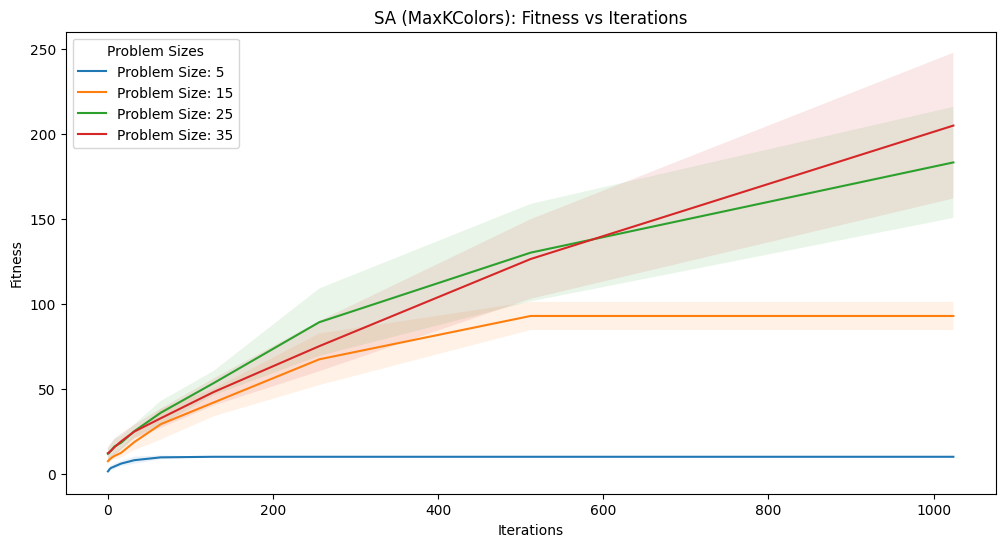

In [9]:
import matplotlib.pyplot as plt

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "Fitness", "schedule_init_temp", "schedule_type"]

# Plotting the Fitness vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size
for size in rhc_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness[min_iteration_for_max_fitness["problem_size"] == size]

    
    # Further filter the main DataFrame for these best hyperparameters
    df = rhc_stats_all[(rhc_stats_all["problem_size"] == size) 
                    
                    ]
   
    # Calculate the mean and standard deviation of Fitness for each iteration
    df_grouped = df.groupby("Iteration")["Fitness"].agg(["mean", "std"]).reset_index()
    print(df_grouped)

    
    # Plot the mean fitness with error bands representing the standard deviation
    plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"Problem Size: {size}")
    plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('SA (MaxKColors): Fitness vs Iterations')
plt.legend(title='Problem Sizes')
plt.show()


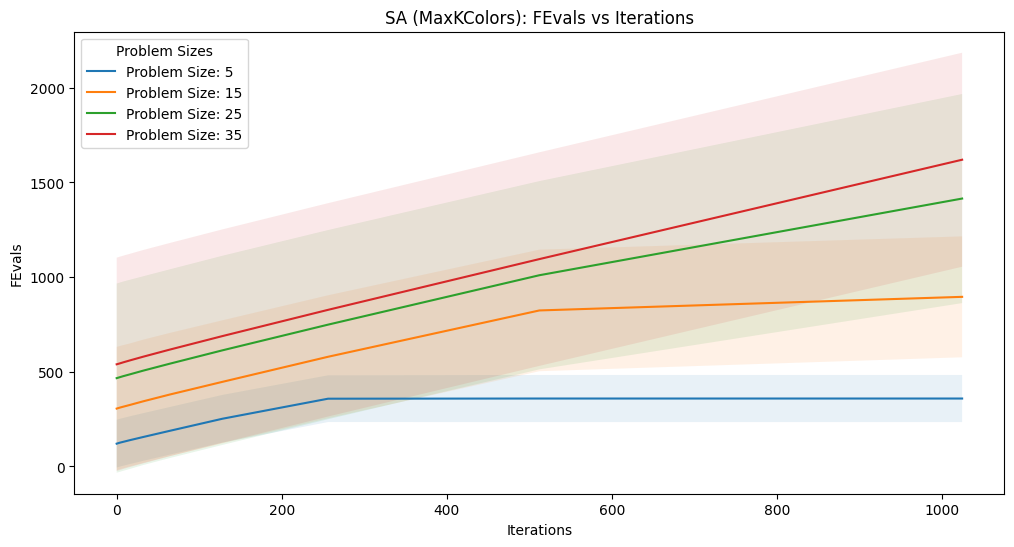

In [11]:
import matplotlib.pyplot as plt

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "FEvals", "schedule_init_temp", "schedule_type"]

# Plotting the FEvals vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size
for size in rhc_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness[min_iteration_for_max_fitness["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = rhc_stats_all[(rhc_stats_all["problem_size"] == size) 
                    ]
    
    # Calculate the mean and standard deviation of FEvals for each iteration
    df_grouped = df.groupby("Iteration")["FEvals"].agg(["mean", "std"]).reset_index()
    
    # If the DataFrame is empty after filtering, skip this iteration
    if df_grouped.empty:
        continue
    
    # Plot the mean FEvals with error bands representing the standard deviation
    plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"Problem Size: {size}")
    plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('FEvals')
plt.title('SA (MaxKColors): FEvals vs Iterations')
plt.legend(title='Problem Sizes')
plt.show()

In [12]:
# the the best avg. max fitness for each problem size
grouped_df = rhc_stats_all.groupby(["problem_size", 'Iteration'])[['Time','Fitness']].mean()

# Grouping by problem_size and Iteration, then calculating the mean Time and Fitness
grouped_df = grouped_df.groupby(["problem_size", 'Iteration'])[['Time','Fitness']].mean().reset_index()

# Finding the first occurrence of max Fitness for each problem size
max_fitness_first_occurrence = grouped_df.loc[grouped_df.groupby("problem_size")['Fitness'].idxmax()]

# Getting the corresponding Time values at those points
max_fitness_times = max_fitness_first_occurrence[['problem_size', 'Iteration', 'Time', 'Fitness']]

print("Wall-Clock time per problem size (For all seeds and retries) by the team it reached avg. max Fitness")
max_fitness_times

Wall-Clock time per problem size (For all seeds and retries) by the team it reached avg. max Fitness


,problem_size,Iteration,Time,Fitness
8,5,128,0.030484,10.000000
22,15,512,0.161117,92.833333
35,25,1024,0.476542,183.166667
47,35,1024,0.680343,204.833333


In [13]:
print("Avg. Wall-Clock time per problem size (For all seeds and retries) On the 1024th iteration")
rhc_stats_all[rhc_stats_all["Iteration"]==1024].groupby(["problem_size"])["Time"].mean()

Avg. Wall-Clock time per problem size (For all seeds and retries) On the 1024th iteration


problem_size
5     0.043592
15    0.181230
25    0.476542
35    0.680343
Name: Time, dtype: float64

# SA: Graphs 

In [14]:

sa_stats_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_stats_total_all_problem_sizes_sa.csv")
sa_curves_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_curves_total_all_problem_sizes_sa.csv")

In [15]:
sa_stats_all

,Unnamed: 0,Iteration,Fitness,FEvals,Time,State,schedule_type,schedule_init_temp,schedule_exp_const,schedule_min_temp,schedule_current_value,Temperature,max_iters,schedule_decay,seed,problem_size
0,0,0,1.0,0,0.000125,"[3, 4, 0, 1, 3]",exponential,0.1,0.005,0.001,0.100000,0.1,1024,NaN,1,5
1,1,1,1.0,2,0.001563,"[0, 4, 0, 1, 3]",exponential,0.1,0.005,0.001,0.099999,0.1,1024,NaN,1,5
2,2,2,1.0,4,0.002642,"[0, 4, 0, 1, 2]",exponential,0.1,0.005,0.001,0.099999,0.1,1024,NaN,1,5
3,3,4,2.0,8,0.003840,"[0, 4, 0, 1, 4]",exponential,0.1,0.005,0.001,0.099998,0.1,1024,NaN,1,5
4,4,8,3.0,15,0.004881,"[3, 1, 1, 1, 4]",exponential,0.1,0.005,0.001,0.099998,0.1,1024,NaN,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,139,64,11.0,123,0.100380,"[4, 15, 0, 32, 23, 29, 17, 25, 9, 12, 16, 12, ...",geometric,5.0,NaN,0.001,4.994958,5.0,1024,0.99,10,35
3452,140,128,27.0,238,0.134267,"[15, 15, 12, 27, 22, 8, 18, 24, 25, 12, 24, 12...",geometric,5.0,NaN,0.001,4.993257,5.0,1024,0.99,10,35
3453,141,256,50.0,420,0.194754,"[7, 6, 12, 12, 4, 18, 18, 6, 25, 12, 24, 12, 2...",geometric,5.0,NaN,0.001,4.990223,5.0,1024,0.99,10,35
3454,142,512,105.0,721,0.291483,"[4, 6, 12, 12, 4, 12, 4, 6, 4, 12, 18, 4, 19, ...",geometric,5.0,NaN,0.001,4.985374,5.0,1024,0.99,10,35


In [18]:
average_fitness_per_iteration = sa_stats_all.groupby(['problem_size', 'Iteration','schedule_init_temp', 'schedule_type'])['Fitness'].mean().reset_index()
std_fitness_per_iteration = sa_stats_all.groupby(['problem_size', 'Iteration','schedule_init_temp', 'schedule_type'])['Fitness'].std().reset_index()

# Rename columns for clarity
average_fitness_per_iteration.rename(columns={'Fitness': 'Average_Fitness'}, inplace=True)
std_fitness_per_iteration.rename(columns={'Fitness': 'Std_Fitness'}, inplace=True)

# Merge the average and standard deviation DataFrames
merged_fitness = pd.merge(average_fitness_per_iteration, std_fitness_per_iteration, on=['problem_size', 'Iteration','schedule_init_temp', 'schedule_type'])

# Group by problem_size to get the max Average_Fitness per problem size
max_avg_fitness_per_problem_size = merged_fitness.groupby('problem_size')['Average_Fitness'].max().reset_index()

# Merge to find the rows with the max Average_Fitness per problem size
max_fitness_merged = pd.merge(merged_fitness, max_avg_fitness_per_problem_size, on=['problem_size', 'Average_Fitness'])

# For each problem_size, filter the row with the minimum Iteration
min_iteration_for_max_fitness = max_fitness_merged.loc[max_fitness_merged.groupby('problem_size')['Iteration'].idxmin()]
print("best hyperparameters and avg fitness for each problem size")
min_iteration_for_max_fitness

best hyperparameters and avg fitness for each problem size


,problem_size,Iteration,schedule_init_temp,schedule_type,Average_Fitness,Std_Fitness
0,5,64,0.1,exponential,10.000000,0.000000
34,15,1024,0.1,exponential,103.000000,0.000000
41,25,1024,0.1,exponential,209.166667,24.830760
43,35,1024,2.0,exponential,215.666667,39.520459


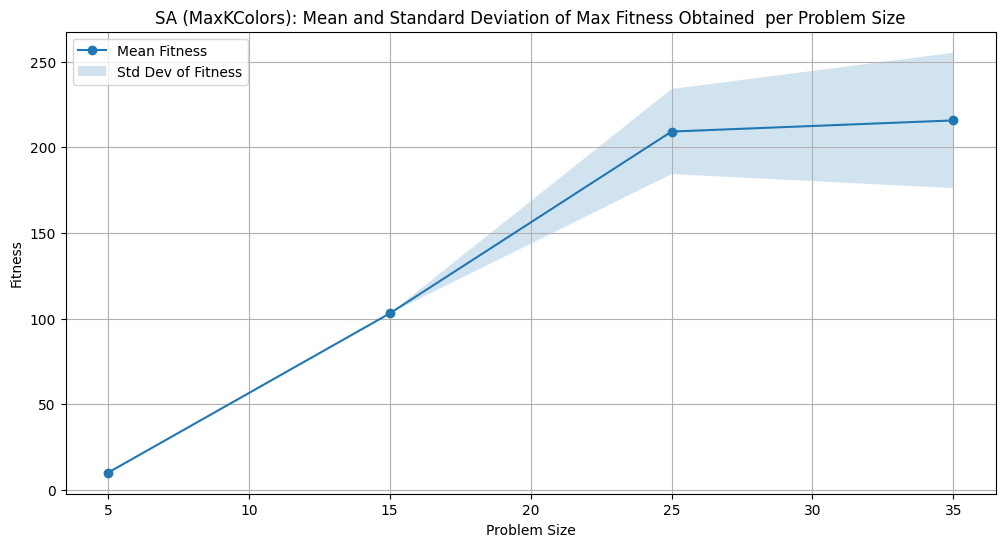

In [21]:
plt.figure(figsize=(12, 6))

# Plotting mean Fitness
plt.plot(sa_stats_all["problem_size"].unique(), min_iteration_for_max_fitness["Average_Fitness"], 'o-', label='Mean Fitness')
plt.fill_between(min_iteration_for_max_fitness["problem_size"], 
                 min_iteration_for_max_fitness["Average_Fitness"] - min_iteration_for_max_fitness["Std_Fitness"], 
                 min_iteration_for_max_fitness["Average_Fitness"]+ min_iteration_for_max_fitness["Std_Fitness"], 
                 alpha=0.2, label='Std Dev of Fitness')



plt.xlabel('Problem Size')
plt.ylabel('Fitness')
plt.title('SA (MaxKColors): Mean and Standard Deviation of Max Fitness Obtained  per Problem Size' )
plt.legend()
plt.grid(True)
plt.show()

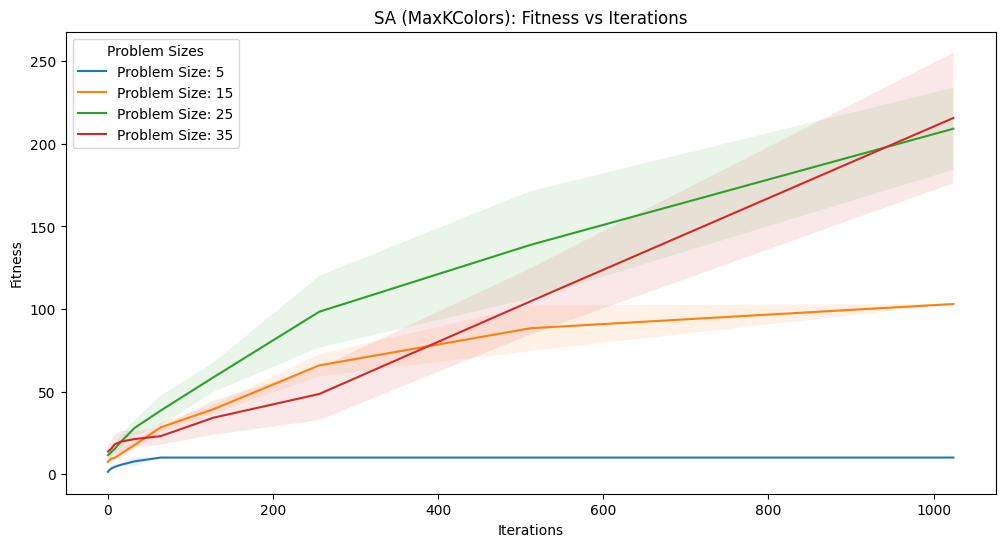

In [22]:
import matplotlib.pyplot as plt

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "Fitness", "schedule_init_temp", "schedule_type"]

# Plotting the Fitness vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size
for size in sa_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness[min_iteration_for_max_fitness["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = sa_stats_all[(sa_stats_all["problem_size"] == size) & 
                      (sa_stats_all["schedule_init_temp"] == best_hyper_params["schedule_init_temp"].iloc[0]) & 
                      (sa_stats_all["schedule_type"] == best_hyper_params["schedule_type"].iloc[0])]
    
    # Calculate the mean and standard deviation of Fitness for each iteration
    df_grouped = df.groupby("Iteration")["Fitness"].agg(["mean", "std"]).reset_index()
    
    # If the DataFrame is empty after filtering, skip this iteration
    if df_grouped.empty:
        continue
    
    # Plot the mean fitness with error bands representing the standard deviation
    plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"Problem Size: {size}")
    plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('SA (MaxKColors): Fitness vs Iterations')
plt.legend(title='Problem Sizes')
plt.show()



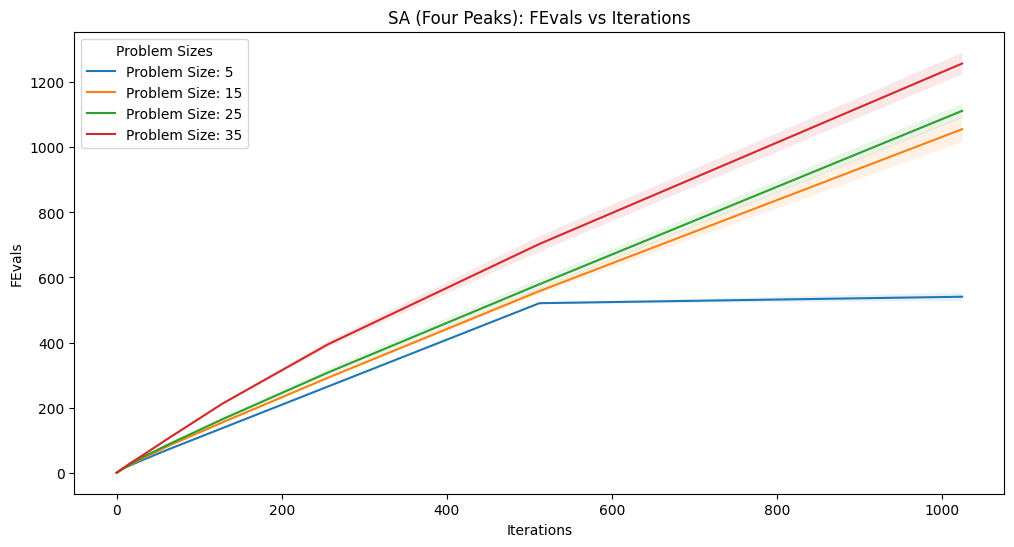

In [23]:
import matplotlib.pyplot as plt

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "FEvals", "schedule_init_temp", "schedule_type"]

# Plotting the FEvals vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size
for size in sa_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness[min_iteration_for_max_fitness["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = sa_stats_all[(sa_stats_all["problem_size"] == size) & 
                      (sa_stats_all["schedule_init_temp"] == best_hyper_params["schedule_init_temp"].iloc[0]) & 
                      (sa_stats_all["schedule_type"] == best_hyper_params["schedule_type"].iloc[0])]
    
    # Calculate the mean and standard deviation of FEvals for each iteration
    df_grouped = df.groupby("Iteration")["FEvals"].agg(["mean", "std"]).reset_index()
    
    # If the DataFrame is empty after filtering, skip this iteration
    if df_grouped.empty:
        continue
    
    # Plot the mean FEvals with error bands representing the standard deviation
    plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"Problem Size: {size}")
    plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('FEvals')
plt.title('SA (MaxKColors): FEvals vs Iterations')
plt.legend(title='Problem Sizes')
plt.show()


In [25]:

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "Time", "Fitness", "schedule_init_temp", "schedule_type"]

# Initialize an empty DataFrame to store results
max_fitness_times_all = pd.DataFrame()

# Iterate through each unique problem size
for size in sa_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness[min_iteration_for_max_fitness["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = sa_stats_all[(sa_stats_all["problem_size"] == size) & 
                      (sa_stats_all["schedule_init_temp"].isin(best_hyper_params["schedule_init_temp"])) & 
                      (sa_stats_all["schedule_type"].isin(best_hyper_params["schedule_type"]))]
    
    # Grouping by problem_size and Iteration, then calculating the mean Time and Fitness
    grouped_df = df.groupby(["problem_size", 'Iteration'])[['Time', 'Fitness']].mean().reset_index()
    
    # Finding the first occurrence of max Fitness for each problem size
    max_fitness_first_occurrence = grouped_df.loc[grouped_df.groupby("problem_size")['Fitness'].idxmax()]
    
    # Append the result to the final DataFrame
    max_fitness_times_all = pd.concat([max_fitness_times_all, max_fitness_first_occurrence])

# Reset the index of the final DataFrame
max_fitness_times_all.reset_index(drop=True, inplace=True)

# Display the results

print("Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the time it reached avg. max Fitness")
max_fitness_times_all

Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the time it reached avg. max Fitness


,problem_size,Iteration,Time,Fitness
0,5,64,0.009697,10.000000
1,15,1024,0.203491,103.000000
2,25,1024,0.281019,209.166667
3,35,1024,0.477912,215.666667


In [26]:
iteration_1024_times_all = pd.DataFrame()

# Iterate through each unique problem size
for size in sa_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness[min_iteration_for_max_fitness["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = sa_stats_all[(sa_stats_all["problem_size"] == size) & 
                      (sa_stats_all["schedule_init_temp"].isin(best_hyper_params["schedule_init_temp"])) & 
                      (sa_stats_all["schedule_type"].isin(best_hyper_params["schedule_type"])) & 
                      (sa_stats_all["Iteration"] == 1024)]
    
    # Calculate the mean and standard deviation of Time and Fitness for iteration 1024
    df_grouped = df.groupby(["problem_size", 'Iteration'])[['Time', 'Fitness']].mean().reset_index()
    
    # Append the result to the final DataFrame
    iteration_1024_times_all = pd.concat([iteration_1024_times_all, df_grouped])
print("Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the 1024th iteration")
# Reset the index of the final DataFrame
iteration_1024_times_all.reset_index(drop=True, inplace=True)
iteration_1024_times_all

Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the 1024th iteration


,problem_size,Iteration,Time,Fitness
0,5,1024,0.059410,10.000000
1,15,1024,0.203491,103.000000
2,25,1024,0.281019,209.166667
3,35,1024,0.477912,215.666667


## GA Graphs

In [27]:

ga_stats_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_stats_total_all_problem_sizes_ga.csv")
ga_curves_all = pd.read_csv("RunData/maxKcolor/maxKcolor_df_run_curves_total_all_problem_sizes_ga.csv")
ga_stats_all

,Unnamed: 0,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters,seed,problem_size
0,0,0,1.0,5,0.000653,"[3, 4, 0, 1, 3]",5,0.05,1024,1,5
1,1,1,3.0,12,0.003257,"[1, 1, 1, 0, 4]",5,0.05,1024,1,5
2,2,2,3.0,18,0.005006,"[1, 1, 1, 0, 4]",5,0.05,1024,1,5
3,3,4,4.0,31,0.007135,"[1, 4, 1, 4, 4]",5,0.05,1024,1,5
4,4,8,4.0,55,0.009222,"[1, 4, 1, 4, 4]",5,0.05,1024,1,5
...,...,...,...,...,...,...,...,...,...,...,...
5755,235,64,141.0,3347,0.860246,"[10, 24, 23, 10, 24, 24, 8, 34, 23, 23, 23, 24...",50,0.75,1024,10,35
5756,236,128,300.0,6630,1.653602,"[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 10, 2...",50,0.75,1024,10,35
5757,237,256,444.0,13167,3.083506,"[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 2...",50,0.75,1024,10,35
5758,238,512,444.0,21888,4.966523,"[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 2...",50,0.75,1024,10,35


In [28]:
average_fitness_per_iteration = ga_stats_all.groupby(['problem_size', 'Iteration','Population Size', 'Mutation Rate'])['Fitness'].mean().reset_index()
std_fitness_per_iteration = ga_stats_all.groupby(['problem_size', 'Iteration','Population Size', 'Mutation Rate'])['Fitness'].std().reset_index()

# Rename columns for clarity
average_fitness_per_iteration.rename(columns={'Fitness': 'Average_Fitness'}, inplace=True)
std_fitness_per_iteration.rename(columns={'Fitness': 'Std_Fitness'}, inplace=True)

# Merge the average and standard deviation DataFrames
merged_fitness = pd.merge(average_fitness_per_iteration, std_fitness_per_iteration, on=['problem_size', 'Iteration','Mutation Rate', 'Population Size'])

# Group by problem_size to get the max Average_Fitness per problem size
max_avg_fitness_per_problem_size = merged_fitness.groupby('problem_size')['Average_Fitness'].max().reset_index()

# Merge to find the rows with the max Average_Fitness per problem size
max_fitness_merged = pd.merge(merged_fitness, max_avg_fitness_per_problem_size, on=['problem_size', 'Average_Fitness'])

# For each problem_size, filter the row with the minimum Iteration
min_iteration_for_max_fitness = max_fitness_merged.loc[max_fitness_merged.groupby('problem_size')['Iteration'].idxmin()]
print("best hyperparameters and avg fitness for each problem size")
min_iteration_for_max_fitness

best hyperparameters and avg fitness for each problem size


,problem_size,Iteration,Population Size,Mutation Rate,Average_Fitness,Std_Fitness
0,5,4,50,0.10,10.0,0.0
112,15,128,30,0.50,103.0,0.0
140,25,256,50,0.75,275.0,0.0
145,35,512,50,0.75,444.0,0.0


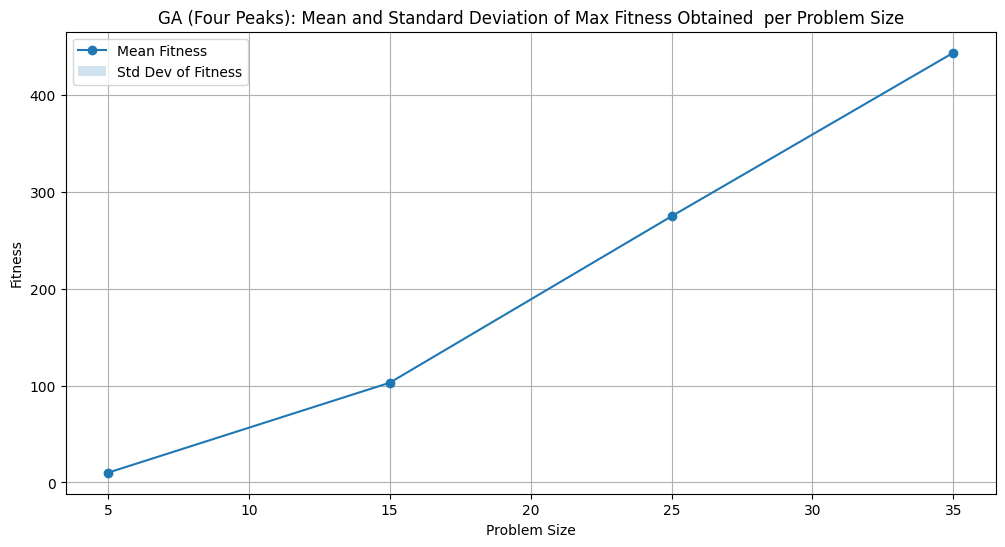

In [29]:
plt.figure(figsize=(12, 6))

# Plotting mean Fitness
plt.plot(min_iteration_for_max_fitness["problem_size"].unique(), min_iteration_for_max_fitness["Average_Fitness"], 'o-', label='Mean Fitness')
plt.fill_between(min_iteration_for_max_fitness["problem_size"], 
                 min_iteration_for_max_fitness["Average_Fitness"] - min_iteration_for_max_fitness["Std_Fitness"], 
                 min_iteration_for_max_fitness["Average_Fitness"]+ min_iteration_for_max_fitness["Std_Fitness"], 
                 alpha=0.2, label='Std Dev of Fitness')



plt.xlabel('Problem Size')
plt.ylabel('Fitness')
plt.title('GA (Four Peaks): Mean and Standard Deviation of Max Fitness Obtained  per Problem Size' )
plt.legend()
plt.grid(True)
plt.show()

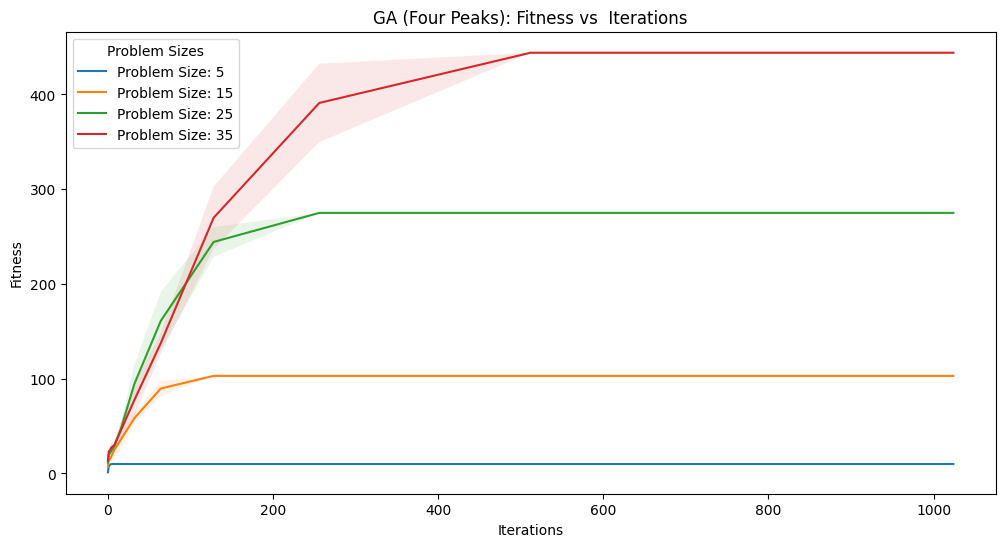

In [30]:
import matplotlib.pyplot as plt

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "Fitness", "schedule_init_temp", "schedule_type"]

# Plotting the Fitness vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size
for size in ga_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness[min_iteration_for_max_fitness["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    # if best_hyper_params.empty:
    #     continue

    # Further filter the main DataFrame for these best hyperparameters
    df = ga_stats_all[(ga_stats_all["problem_size"] == size) & 
                      (ga_stats_all["Population Size"] == best_hyper_params["Population Size"].iloc[0]) & 
                      (ga_stats_all["Mutation Rate"] == best_hyper_params["Mutation Rate"].iloc[0])]
    

    # Calculate the mean and standard deviation of Fitness for each iteration
    df_grouped = df.groupby("Iteration")["Fitness"].agg(["mean", "std"]).reset_index()
    
    # If the DataFrame is empty after filtering, skip this iteration
    # if df_grouped.empty:
    #     continue
    
    # Plot the mean fitness with error bands representing the standard deviation
    plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"Problem Size: {size}")
    plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('GA (Four Peaks): Fitness vs  Iterations')
plt.legend(title='Problem Sizes')
plt.show()


      Unnamed: 0  Iteration  Fitness  FEvals      Time  \
0              0          0      2.0       5  0.000268   
1              1          1      6.0      12  0.004024   
2              2          2      6.0      18  0.005597   
3              3          4     16.0      31  0.007081   
4              4          8     16.0      55  0.008706   
...          ...        ...      ...     ...       ...   
8995         295         64     25.0    4626  0.383429   
8996         296        128     31.0    9175  0.584230   
8997         297        256     71.0   18284  0.996239   
8998         298        512    137.0   36492  1.941531   
8999         299       1024    160.0   72851  4.158257   

                                                  State  Population Size  \
0                        [1, 1, 0, 0, 1, 1, 1, 1, 1, 0]                5   
1                        [1, 1, 1, 1, 1, 1, 0, 1, 1, 0]                5   
2                        [1, 1, 1, 1, 1, 1, 0, 1, 1, 0]                5   

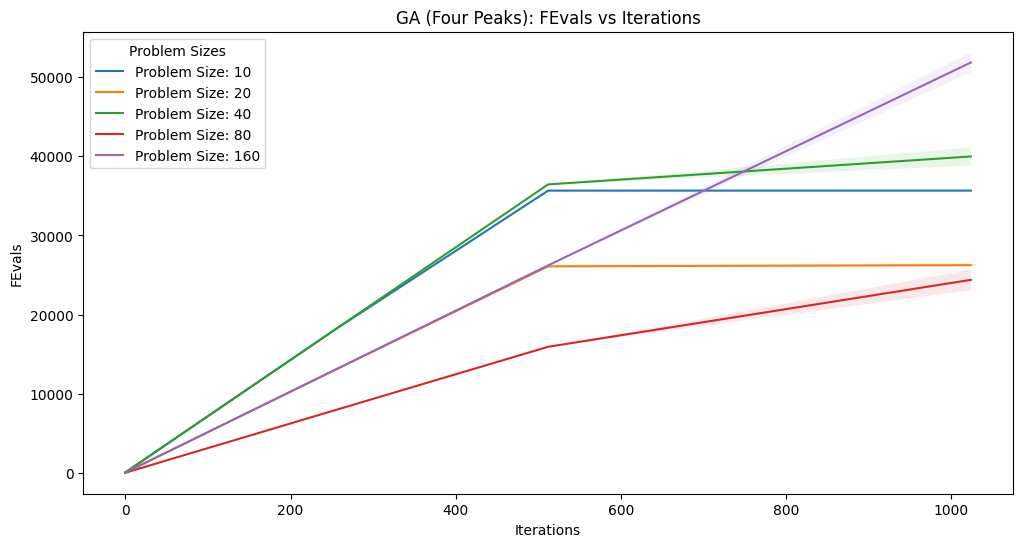

In [242]:
import matplotlib.pyplot as plt

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "FEvals", "schedule_init_temp", "schedule_type"]

# Plotting the FEvals vs Function Evaluations
plt.figure(figsize=(12, 6))

# Iterate through each unique problem size
for size in ga_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness[min_iteration_for_max_fitness["problem_size"] == size]
   
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    # if best_hyper_params.empty:
    #     continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = ga_stats_all[(ga_stats_all["problem_size"] == size) & 
                      (ga_stats_all["Population Size"] == best_hyper_params["Population Size"].iloc[0]) & 
                      (ga_stats_all["Mutation Rate"] == best_hyper_params["Mutation Rate"].iloc[0])]
    print(ga_stats_all)
    # Calculate the mean and standard deviation of FEvals for each iteration
    df_grouped = df.groupby("Iteration")["FEvals"].agg(["mean", "std"]).reset_index()
    
    # If the DataFrame is empty after filtering, skip this iteration
    if df_grouped.empty:
        continue
    
    # Plot the mean FEvals with error bands representing the standard deviation
    plt.plot(df_grouped["Iteration"], df_grouped["mean"], label=f"Problem Size: {size}")
    plt.fill_between(df_grouped["Iteration"], df_grouped["mean"] - df_grouped["std"], df_grouped["mean"] + df_grouped["std"], alpha=0.1)

# Set the labels and title of the plot
plt.xlabel('Iterations')
plt.ylabel('FEvals')
plt.title('GA (Four Peaks): FEvals vs Iterations')
plt.legend(title='Problem Sizes')
plt.show()

In [245]:

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "Time", "Fitness", "schedule_init_temp", "schedule_type"]

# Initialize an empty DataFrame to store results
max_fitness_times_all = pd.DataFrame()

# Iterate through each unique problem size
for size in sa_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness[min_iteration_for_max_fitness["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = sa_stats_all[(ga_stats_all["problem_size"] == size) & 
                      (ga_stats_all["Population Size"].isin(best_hyper_params["Population Size"])) & 
                      (ga_stats_all["Mutation Rate"].isin(best_hyper_params["Mutation Rate"]))]
    
    # Grouping by problem_size and Iteration, then calculating the mean Time and Fitness
    grouped_df = df.groupby(["problem_size", 'Iteration'])[['Time', 'Fitness']].mean().reset_index()
    
    # Finding the first occurrence of max Fitness for each problem size
    max_fitness_first_occurrence = grouped_df.loc[grouped_df.groupby("problem_size")['Fitness'].idxmax()]
    
    # Append the result to the final DataFrame
    max_fitness_times_all = pd.concat([max_fitness_times_all, max_fitness_first_occurrence])

# Reset the index of the final DataFrame
max_fitness_times_all.reset_index(drop=True, inplace=True)

# Display the results

print("Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the time it reached avg. max Fitness")
max_fitness_times_all

Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the time it reached avg. max Fitness


,problem_size,Iteration,Time,Fitness
0,10,256,0.064902,17.000000
1,20,512,0.080842,27.500000
2,40,1024,0.165148,40.000000
3,40,1024,0.161923,40.000000
4,80,1024,0.193282,26.666667
5,160,1024,0.189362,9.000000
6,160,1024,0.198438,20.000000


In [246]:

# Assuming sa_stats_all is your DataFrame with columns ["problem_size", "Iteration", "Time", "Fitness", "schedule_init_temp", "schedule_type"]

# Initialize an empty DataFrame to store results
max_fitness_times_all = pd.DataFrame()

# Iterate through each unique problem size
for size in sa_stats_all["problem_size"].unique():
    # Filter the best hyperparameters for the given problem size
    best_hyper_params = min_iteration_for_max_fitness[min_iteration_for_max_fitness["problem_size"] == size]
    
    # If there are no best hyperparameters for the current problem size, skip this iteration
    if best_hyper_params.empty:
        continue
    
    # Further filter the main DataFrame for these best hyperparameters
    df = sa_stats_all[(ga_stats_all["problem_size"] == size) & 
                      (ga_stats_all["Population Size"].isin(best_hyper_params["Population Size"])) & 
                      (ga_stats_all["Mutation Rate"].isin(best_hyper_params["Mutation Rate"]))]
    
    # Grouping by problem_size and Iteration, then calculating the mean Time and Fitness
    grouped_df = df.groupby(["problem_size", 'Iteration'])[['Time', 'Fitness']].mean().reset_index()
    
    # Finding the first occurrence of max Fitness for each problem size
    max_fitness_first_occurrence = grouped_df.loc[grouped_df.groupby("problem_size")['Fitness'].idxmax()]
    
    # Append the result to the final DataFrame
    max_fitness_times_all = pd.concat([max_fitness_times_all, max_fitness_first_occurrence])

# Reset the index of the final DataFrame
max_fitness_times_all.reset_index(drop=True, inplace=True)

# Display the results

print("Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the time it reached avg. max Fitness")
max_fitness_times_all

Wall-Clock time per problem size (For all seeds and best hyperparameters per problem) by the time it reached avg. max Fitness


,problem_size,Iteration,Time,Fitness
0,10,256,0.064902,17.000000
1,20,512,0.080842,27.500000
2,40,1024,0.165148,40.000000
3,40,1024,0.161923,40.000000
4,80,1024,0.193282,26.666667
5,160,1024,0.189362,9.000000
6,160,1024,0.198438,20.000000
